In [1]:
import dropbox
import os
import numpy as np
import pandas as pd
from scipy.stats import t
import math
import collections
from PIL import Image
from dropbox import DropboxOAuth2FlowNoRedirect
import matplotlib.pyplot as plt
import cv2
import pypyodbc
import sys
import traceback

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, concatenate, Input, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical  #?
from keras.optimizers import Adam

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cnxn = pypyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                      "Server=028-GUMUS1-SRV;"
                      "Database=KOTON_DB;"
                      "Trusted_Connection=yes;")

In [3]:
access_token='0DQLcsXIojcAAAAAAAgybeB3DOmXKK7bRTLyYwkthbrAiGmpQR4AuGINQkjBXhif'
dbx = dropbox.Dropbox(access_token)

In [4]:
retrieved_image_df = pd.read_excel('C:/Users/Recep/Koton/Data/retrieved_image_list.xlsx', sheet_name='Sheet1')

In [5]:
def data_set(codes, indexes):
    """Takes list of option codes as input and returns related dataset, response set (sales amount)
    and genuine option codes that included in e-commerce table.
    """
    
    if len(codes)>2000:
        numOfBatches = 100
    else:
        numOfBatches = 1
    
    string_tar = "SELECT [OptionCode] \
      ,[Ratio] \
  FROM [KOTON_DB].[dbo].[Ratio_table_week] Where ratio is not null and ("
    
    codes_split = np.array_split(codes, numOfBatches)
    indexes_split = np.array_split(indexes, numOfBatches)
    
    # to prevent empty targets
    gen_codes = []
    gen_indexes = []
    target = []
    
    for batch in range(numOfBatches):
        _ =[]
        flag2 = True
        for i in codes_split[batch]:
            if flag2:
                _.append("OptionCode='"+i+"'")
                flag2 = False
            else:
                 _.append(" OR OptionCode='"+i+"'")
        query2 = string_tar + ''.join(_) + ')'
        temp = pd.read_sql_query(query2, cnxn, index_col='optioncode')
        target.append(temp)
    target = pd.concat(target)

    for code, index in zip(codes, indexes):
        try:
            target.loc[code]
            gen_codes.append(code)
            gen_indexes.append(index)
        except:
            pass        
        
    
    string_inp = "SELECT * \
  FROM [KOTON_DB].[dbo].[Input_table] \
  WHERE "
    
#     numOfBatches = max(min(len(gen_indexes), numOfBatches), 1)
    numOfBatches = max(min(len(gen_indexes), numOfBatches), 1)
    gen_codes_splited = np.array_split(gen_codes, numOfBatches)
    dataset = []
    
    for batch in range(numOfBatches):
        _ =[]
        flag1 = True
        for i in gen_codes_splited[batch]:
            if flag1:
                _.append("OptionCode='"+i+"'")
                flag1 = False
            else:
                 _.append(" OR OptionCode='"+i+"'")
        query1 = string_inp + ''.join(_)
        dataset.append(pd.read_sql_query(query1, cnxn, index_col='optioncode'))
    
    dataset = pd.concat(dataset)
    
    
    return dataset, target, gen_codes, gen_indexes

In [6]:
number_of_samples = 50
startIndex = 16000

* increment querysinde aggregate / **stock azalmalarini dus** ok
* Correct image index. ok
* Check images ok
* price ekle ok
* test sete bol ok
* modelle traini ayir ok
* inv ratio gunluk yap ok

In [9]:
def getImages_n_train(numberSamples, startIndex, batchSize=64, return_data=False):
    errorLog = []
    bn_model = Xception(include_top=False, weights='imagenet', pooling='max')  #, pooling='avg'
    
    first = Input(shape=(2048,))
#     first = Flatten()(first_input)
    
    second = Input(shape=(193,)) #change according to columns
#     second = Dense(10, activation='relu')(second_)
    
    model = concatenate([first, second], axis=1)
    model = BatchNormalization()(model)
    model = Dense(512, activation='sigmoid')(model)
    model = Dropout(0.5)(model)
    model = Dense(256, activation='sigmoid')(model)
    model = Dropout(0.5)(model)
    model = Dense(128, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(1, activation='linear')(model)
    
    model_ = Model(inputs=[first, second], outputs=model)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=0.5)
    model_.compile(optimizer=adam,
                  loss='mean_squared_error', metrics=['mae'])
    
    codes = []
    idx = []
    for picture_index in range(startIndex,startIndex + numberSamples):
        code = retrieved_image_df.iloc[picture_index].name
        codes.append(code)
        idx.append(picture_index)
    
    dset, tar, gen_codes, gen_indexes = data_set(codes, idx)
#     dset = dset.apply(LabelEncoder().fit_transform)
    dset = pd.get_dummies(dset)
    print(dset.shape)
       
    if batchSize>dset.shape[0]:
        batchSize = dset.shape[0]
        print('Batch size is automatically adjusted.')
    
    dset, dset_test, tar, tar_test = train_test_split(dset, tar, test_size=0.01, random_state=42)
    gen_codes, gen_codes_test, gen_indexes, gen_indexes_test = train_test_split(gen_codes, gen_indexes, 
                                                                                test_size=0.01, random_state=42)
    print(dset.shape)
    
    numOfBatches, lastBatch = divmod(dset.shape[0], batchSize-1)
    dsets = np.array_split(dset, numOfBatches)
    tars = np.array_split(tar, numOfBatches)
    gen_codes = np.array_split(gen_codes, numOfBatches)
    gen_indexes = np.array_split(gen_indexes, numOfBatches)
    
    valid_pic1 =[]
    for code, picture_index in zip(gen_codes_test, gen_indexes_test):
        im_index = retrieved_image_df.iloc[picture_index]['image1'+'_index']        
        if (math.isnan(float(im_index))==False):
            filename = str(code).lower()+'_'+'image1'+'_'+str(int(im_index))+'.jpg'
            path = '/Koton_Image_Files/'+filename
            try:
                md, res = dbx.files_download(path)
                temp_pic = cv2.cvtColor(cv2.resize(cv2.imdecode(np.frombuffer(res.content, dtype=np.uint8), -1), (299,299)), cv2.COLOR_BGR2RGB)
                assert temp_pic.shape == (299, 299, 3)
                valid_pic1.append(temp_pic)
            except:
                errorLog.append(path+' Not found')
    valid_pic1 = preprocess_input(np.array(valid_pic1))
    valid_bottleneck_features = bn_model.predict(valid_pic1)
    
    for batch in range(numOfBatches):
        pic1 =[]
        print('Batch: '+str(batch+1)+'/'+str(numOfBatches))
        for code, picture_index in zip(gen_codes[batch], gen_indexes[batch]):
            im_index = retrieved_image_df.iloc[picture_index]['image1'+'_index']        
            if (math.isnan(float(im_index))==False):
                filename = str(code).lower()+'_'+'image1'+'_'+str(int(im_index))+'.jpg'
                path = '/Koton_Image_Files/'+filename
                try:
                    md, res = dbx.files_download(path)
                    temp_pic = cv2.cvtColor(cv2.resize(cv2.imdecode(np.frombuffer(res.content, dtype=np.uint8), -1), (299,299)), cv2.COLOR_BGR2RGB)
                    assert temp_pic.shape == (299, 299, 3)
                    pic1.append(temp_pic)
                except:
                    errorLog.append(path+' Not found')
                    batch += 1 #ignore defective batch
        pic1 = preprocess_input(np.array(pic1))
        bottleneck_features = bn_model.predict(pic1)
        try:
            model_.fit([bottleneck_features, dsets[batch]], tars[batch], validation_data=([valid_bottleneck_features, dset_test], tar_test),
                  epochs=60)
        except:
            exc_type, exc_value, exc_traceback = sys.exc_info()
            lines = traceback.format_exception(exc_type, exc_value, exc_traceback)
            errorLog.append(''.join('!! ' + line for line in lines))  
      
    if return_data:
        return model_, errorLog, dset, dset_test, tar, tar_test, gen_codes, gen_codes_test, gen_indexes, gen_indexes_test
    else:
        return model_, errorLog
                    

In [134]:
dset.shape

(6082, 193)

In [10]:
model, errorLog, dset, dset_test, tar, tar_test, gen_codes, gen_codes_test, gen_indexes, gen_indexes_test = getImages_n_train(40000, 1724, 64, return_data=True)

(6144, 193)
(6082, 193)
Batch: 1/96
Train on 64 samples, validate on 62 samples
Epoch 1/60
64/64 [==============================] - 2s 25ms/step - loss: 1.1206 - mean_absolute_error: 0.8312 - val_loss: 0.8640 - val_mean_absolute_error: 0.8378
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 1.7087 - mean_absolute_error: 0.9812 - val_loss: 0.2539 - val_mean_absolute_error: 0.4325
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.8047 - mean_absolute_error: 0.7163 - val_loss: 0.4138 - val_mean_absolute_error: 0.5152
Epoch 4/60
64/64 [==============================] - 0s 1ms/step - loss: 0.9317 - mean_absolute_error: 0.7991 - val_loss: 0.4424 - val_mean_absolute_error: 0.5435
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.6788 - mean_absolute_error: 0.6710 - val_loss: 0.2046 - val_mean_absolute_error: 0.3523
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.6886 - mean_absolute_error: 0.6740 

Epoch 51/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0402 - mean_absolute_error: 0.1592 - val_loss: 0.2090 - val_mean_absolute_error: 0.3664
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0539 - mean_absolute_error: 0.1747 - val_loss: 0.2112 - val_mean_absolute_error: 0.3650
Epoch 53/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mean_absolute_error: 0.1608 - val_loss: 0.2136 - val_mean_absolute_error: 0.3632
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0811 - mean_absolute_error: 0.2142 - val_loss: 0.2105 - val_mean_absolute_error: 0.3618
Epoch 55/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_absolute_error: 0.1699 - val_loss: 0.2050 - val_mean_absolute_error: 0.3601
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0579 - mean_absolute_error: 0.1755 - val_loss: 0.1987 - val_mean_absolute_error: 0.3569
Epoch 57/60
64/64 [===

Epoch 41/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0416 - mean_absolute_error: 0.1636 - val_loss: 0.1811 - val_mean_absolute_error: 0.3258
Epoch 42/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0467 - mean_absolute_error: 0.1550 - val_loss: 0.1807 - val_mean_absolute_error: 0.3256
Epoch 43/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0379 - mean_absolute_error: 0.1569 - val_loss: 0.1820 - val_mean_absolute_error: 0.3261
Epoch 44/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0354 - mean_absolute_error: 0.1510 - val_loss: 0.1835 - val_mean_absolute_error: 0.3270
Epoch 45/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0553 - mean_absolute_error: 0.1888 - val_loss: 0.1841 - val_mean_absolute_error: 0.3272
Epoch 46/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0425 - mean_absolute_error: 0.1564 - val_loss: 0.1832 - val_mean_absolute_error: 0.3264
Epoch 47/60
64/64 [===

Epoch 31/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0203 - mean_absolute_error: 0.1058 - val_loss: 0.1995 - val_mean_absolute_error: 0.3448
Epoch 32/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0266 - mean_absolute_error: 0.1172 - val_loss: 0.1993 - val_mean_absolute_error: 0.3448
Epoch 33/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0.1164 - val_loss: 0.1983 - val_mean_absolute_error: 0.3445
Epoch 34/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0223 - mean_absolute_error: 0.1151 - val_loss: 0.1970 - val_mean_absolute_error: 0.3439
Epoch 35/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0269 - mean_absolute_error: 0.1226 - val_loss: 0.1975 - val_mean_absolute_error: 0.3443
Epoch 36/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.0998 - val_loss: 0.1989 - val_mean_absolute_error: 0.3455
Epoch 37/60
64/64 [===

Epoch 21/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0424 - mean_absolute_error: 0.1564 - val_loss: 0.2009 - val_mean_absolute_error: 0.3609
Epoch 22/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0242 - mean_absolute_error: 0.1299 - val_loss: 0.2015 - val_mean_absolute_error: 0.3612
Epoch 23/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_absolute_error: 0.1380 - val_loss: 0.1990 - val_mean_absolute_error: 0.3585
Epoch 24/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0314 - mean_absolute_error: 0.1306 - val_loss: 0.1969 - val_mean_absolute_error: 0.3559
Epoch 25/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0303 - mean_absolute_error: 0.1319 - val_loss: 0.1961 - val_mean_absolute_error: 0.3540
Epoch 26/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0340 - mean_absolute_error: 0.1338 - val_loss: 0.1973 - val_mean_absolute_error: 0.3562
Epoch 27/60
64/64 [===

Epoch 11/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0518 - mean_absolute_error: 0.1878 - val_loss: 0.1558 - val_mean_absolute_error: 0.3254
Epoch 12/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0595 - mean_absolute_error: 0.2050 - val_loss: 0.1564 - val_mean_absolute_error: 0.3253
Epoch 13/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0562 - mean_absolute_error: 0.2004 - val_loss: 0.1582 - val_mean_absolute_error: 0.3258
Epoch 14/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0390 - mean_absolute_error: 0.1610 - val_loss: 0.1594 - val_mean_absolute_error: 0.3255
Epoch 15/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0450 - mean_absolute_error: 0.1739 - val_loss: 0.1610 - val_mean_absolute_error: 0.3258
Epoch 16/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0493 - mean_absolute_error: 0.1814 - val_loss: 0.1626 - val_mean_absolute_error: 0.3258
Epoch 17/60
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: 0.2204 - mean_absolute_error: 0.3857 - val_loss: 0.1678 - val_mean_absolute_error: 0.3271
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 0.2077 - mean_absolute_error: 0.3686 - val_loss: 0.1656 - val_mean_absolute_error: 0.3241
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1684 - mean_absolute_error: 0.3297 - val_loss: 0.1636 - val_mean_absolute_error: 0.3212
Epoch 4/60
64/64 [==============================] - 0s 2ms/step - loss: 0.1689 - mean_absolute_error: 0.3189 - val_loss: 0.1630 - val_mean_absolute_error: 0.3210
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1412 - mean_absolute_error: 0.2905 - val_loss: 0.1619 - val_mean_absolute_error: 0.3204
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1231 - mean_absolute_error: 0.2677 - val_loss: 0.1598 - val_mean_absolute_error: 0.3194
Epoch 7/60
64/64 [=====================

64/64 [==============================] - 0s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.1034 - val_loss: 0.1735 - val_mean_absolute_error: 0.3371
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.1014 - val_loss: 0.1740 - val_mean_absolute_error: 0.3364
Epoch 53/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0227 - mean_absolute_error: 0.1195 - val_loss: 0.1743 - val_mean_absolute_error: 0.3362
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1059 - val_loss: 0.1745 - val_mean_absolute_error: 0.3372
Epoch 55/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.1039 - val_loss: 0.1752 - val_mean_absolute_error: 0.3382
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0206 - mean_absolute_error: 0.1089 - val_loss: 0.1756 - val_mean_absolute_error: 0.3394
Epoch 57/60
64/64 [===============

Epoch 41/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0802 - val_loss: 0.1918 - val_mean_absolute_error: 0.3508
Epoch 42/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_absolute_error: 0.1087 - val_loss: 0.1943 - val_mean_absolute_error: 0.3551
Epoch 43/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.1031 - val_loss: 0.1984 - val_mean_absolute_error: 0.3604
Epoch 44/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0196 - mean_absolute_error: 0.0996 - val_loss: 0.2012 - val_mean_absolute_error: 0.3632
Epoch 45/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0205 - mean_absolute_error: 0.1063 - val_loss: 0.2014 - val_mean_absolute_error: 0.3635
Epoch 46/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0187 - mean_absolute_error: 0.1033 - val_loss: 0.1992 - val_mean_absolute_error: 0.3606
Epoch 47/60
64/64 [===

Epoch 31/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0308 - mean_absolute_error: 0.1400 - val_loss: 0.1674 - val_mean_absolute_error: 0.3357
Epoch 32/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0237 - mean_absolute_error: 0.1259 - val_loss: 0.1667 - val_mean_absolute_error: 0.3359
Epoch 33/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0230 - mean_absolute_error: 0.1172 - val_loss: 0.1668 - val_mean_absolute_error: 0.3375
Epoch 34/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0283 - mean_absolute_error: 0.1345 - val_loss: 0.1659 - val_mean_absolute_error: 0.3372
Epoch 35/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_absolute_error: 0.1095 - val_loss: 0.1653 - val_mean_absolute_error: 0.3359
Epoch 36/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0181 - mean_absolute_error: 0.0981 - val_loss: 0.1651 - val_mean_absolute_error: 0.3352
Epoch 37/60
64/64 [===

Epoch 21/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0218 - mean_absolute_error: 0.1185 - val_loss: 0.1828 - val_mean_absolute_error: 0.3489
Epoch 22/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0212 - mean_absolute_error: 0.1097 - val_loss: 0.1824 - val_mean_absolute_error: 0.3488
Epoch 23/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0165 - mean_absolute_error: 0.0977 - val_loss: 0.1820 - val_mean_absolute_error: 0.3489
Epoch 24/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1149 - val_loss: 0.1824 - val_mean_absolute_error: 0.3499
Epoch 25/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0204 - mean_absolute_error: 0.0993 - val_loss: 0.1820 - val_mean_absolute_error: 0.3497
Epoch 26/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0143 - mean_absolute_error: 0.0959 - val_loss: 0.1821 - val_mean_absolute_error: 0.3491
Epoch 27/60
64/64 [===

Epoch 11/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0678 - mean_absolute_error: 0.2097 - val_loss: 0.1560 - val_mean_absolute_error: 0.3448
Epoch 12/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0421 - mean_absolute_error: 0.1696 - val_loss: 0.1573 - val_mean_absolute_error: 0.3455
Epoch 13/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0404 - mean_absolute_error: 0.1551 - val_loss: 0.1591 - val_mean_absolute_error: 0.3468
Epoch 14/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0289 - mean_absolute_error: 0.1388 - val_loss: 0.1615 - val_mean_absolute_error: 0.3484
Epoch 15/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0294 - mean_absolute_error: 0.1434 - val_loss: 0.1644 - val_mean_absolute_error: 0.3505
Epoch 16/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0394 - mean_absolute_error: 0.1564 - val_loss: 0.1648 - val_mean_absolute_error: 0.3498
Epoch 17/60
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: 0.1776 - mean_absolute_error: 0.3480 - val_loss: 0.1539 - val_mean_absolute_error: 0.3345
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1650 - mean_absolute_error: 0.3315 - val_loss: 0.1510 - val_mean_absolute_error: 0.3315
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1230 - mean_absolute_error: 0.2850 - val_loss: 0.1486 - val_mean_absolute_error: 0.3285
Epoch 4/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1108 - mean_absolute_error: 0.2660 - val_loss: 0.1471 - val_mean_absolute_error: 0.3265
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1094 - mean_absolute_error: 0.2687 - val_loss: 0.1456 - val_mean_absolute_error: 0.3254
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0971 - mean_absolute_error: 0.2546 - val_loss: 0.1444 - val_mean_absolute_error: 0.3249
Epoch 7/60
64/64 [=====================

64/64 [==============================] - 0s 1ms/step - loss: 0.0169 - mean_absolute_error: 0.1078 - val_loss: 0.1641 - val_mean_absolute_error: 0.3273
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1090 - val_loss: 0.1638 - val_mean_absolute_error: 0.3267
Epoch 53/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0868 - val_loss: 0.1644 - val_mean_absolute_error: 0.3272
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0934 - val_loss: 0.1651 - val_mean_absolute_error: 0.3276
Epoch 55/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.1006 - val_loss: 0.1645 - val_mean_absolute_error: 0.3274
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0209 - mean_absolute_error: 0.1059 - val_loss: 0.1626 - val_mean_absolute_error: 0.3260
Epoch 57/60
64/64 [===============

64/64 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.1142 - val_loss: 0.1600 - val_mean_absolute_error: 0.3276
Epoch 42/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.0988 - val_loss: 0.1643 - val_mean_absolute_error: 0.3345
Epoch 43/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.1087 - val_loss: 0.1707 - val_mean_absolute_error: 0.3417
Epoch 44/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.1163 - val_loss: 0.1728 - val_mean_absolute_error: 0.3428
Epoch 45/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0173 - mean_absolute_error: 0.1108 - val_loss: 0.1700 - val_mean_absolute_error: 0.3386
Epoch 46/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0345 - mean_absolute_error: 0.1396 - val_loss: 0.1644 - val_mean_absolute_error: 0.3320
Epoch 47/60
64/64 [===============

64/64 [==============================] - 0s 1ms/step - loss: 0.0144 - mean_absolute_error: 0.0998 - val_loss: 0.1739 - val_mean_absolute_error: 0.3462
Epoch 32/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1079 - val_loss: 0.1744 - val_mean_absolute_error: 0.3460
Epoch 33/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0161 - mean_absolute_error: 0.0960 - val_loss: 0.1752 - val_mean_absolute_error: 0.3473
Epoch 34/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0859 - val_loss: 0.1759 - val_mean_absolute_error: 0.3488
Epoch 35/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.1169 - val_loss: 0.1757 - val_mean_absolute_error: 0.3490
Epoch 36/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0197 - mean_absolute_error: 0.1137 - val_loss: 0.1754 - val_mean_absolute_error: 0.3486
Epoch 37/60
64/64 [===============

Epoch 21/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1130 - val_loss: 0.1679 - val_mean_absolute_error: 0.3487
Epoch 22/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0196 - mean_absolute_error: 0.1083 - val_loss: 0.1699 - val_mean_absolute_error: 0.3513
Epoch 23/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0902 - val_loss: 0.1723 - val_mean_absolute_error: 0.3540
Epoch 24/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0182 - mean_absolute_error: 0.0998 - val_loss: 0.1724 - val_mean_absolute_error: 0.3541
Epoch 25/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.1006 - val_loss: 0.1723 - val_mean_absolute_error: 0.3539
Epoch 26/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0256 - mean_absolute_error: 0.1220 - val_loss: 0.1734 - val_mean_absolute_error: 0.3554
Epoch 27/60
64/64 [===

Epoch 11/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0425 - mean_absolute_error: 0.1669 - val_loss: 0.1745 - val_mean_absolute_error: 0.3581
Epoch 12/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0365 - mean_absolute_error: 0.1571 - val_loss: 0.1778 - val_mean_absolute_error: 0.3576
Epoch 13/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0278 - mean_absolute_error: 0.1315 - val_loss: 0.1801 - val_mean_absolute_error: 0.3563
Epoch 14/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0331 - mean_absolute_error: 0.1516 - val_loss: 0.1795 - val_mean_absolute_error: 0.3528
Epoch 15/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0362 - mean_absolute_error: 0.1499 - val_loss: 0.1720 - val_mean_absolute_error: 0.3441
Epoch 16/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0305 - mean_absolute_error: 0.1430 - val_loss: 0.1642 - val_mean_absolute_error: 0.3357
Epoch 17/60
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: 0.1819 - mean_absolute_error: 0.3473 - val_loss: 0.1678 - val_mean_absolute_error: 0.3452
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1459 - mean_absolute_error: 0.2985 - val_loss: 0.1617 - val_mean_absolute_error: 0.3422
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1384 - mean_absolute_error: 0.3049 - val_loss: 0.1564 - val_mean_absolute_error: 0.3406
Epoch 4/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1306 - mean_absolute_error: 0.2983 - val_loss: 0.1514 - val_mean_absolute_error: 0.3369
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1117 - mean_absolute_error: 0.2806 - val_loss: 0.1487 - val_mean_absolute_error: 0.3357
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0991 - mean_absolute_error: 0.2605 - val_loss: 0.1475 - val_mean_absolute_error: 0.3344
Epoch 7/60
64/64 [=====================

64/64 [==============================] - 0s 1ms/step - loss: 0.0163 - mean_absolute_error: 0.1019 - val_loss: 0.1816 - val_mean_absolute_error: 0.3457
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1075 - val_loss: 0.1832 - val_mean_absolute_error: 0.3456
Epoch 53/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0239 - mean_absolute_error: 0.1182 - val_loss: 0.1828 - val_mean_absolute_error: 0.3443
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0143 - mean_absolute_error: 0.0975 - val_loss: 0.1830 - val_mean_absolute_error: 0.3440
Epoch 55/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.1051 - val_loss: 0.1826 - val_mean_absolute_error: 0.3447
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0983 - val_loss: 0.1812 - val_mean_absolute_error: 0.3441
Epoch 57/60
64/64 [===============

64/64 [==============================] - 0s 1ms/step - loss: 0.0151 - mean_absolute_error: 0.0979 - val_loss: 0.1675 - val_mean_absolute_error: 0.3331
Epoch 42/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.0972 - val_loss: 0.1681 - val_mean_absolute_error: 0.3336
Epoch 43/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0112 - mean_absolute_error: 0.0877 - val_loss: 0.1688 - val_mean_absolute_error: 0.3343
Epoch 44/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0141 - mean_absolute_error: 0.0873 - val_loss: 0.1694 - val_mean_absolute_error: 0.3350
Epoch 45/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0113 - mean_absolute_error: 0.0812 - val_loss: 0.1700 - val_mean_absolute_error: 0.3357
Epoch 46/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0187 - mean_absolute_error: 0.1044 - val_loss: 0.1693 - val_mean_absolute_error: 0.3352
Epoch 47/60
64/64 [===============

Epoch 31/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.1077 - val_loss: 0.1589 - val_mean_absolute_error: 0.3248
Epoch 32/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_absolute_error: 0.1177 - val_loss: 0.1586 - val_mean_absolute_error: 0.3244
Epoch 33/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0922 - val_loss: 0.1592 - val_mean_absolute_error: 0.3248
Epoch 34/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0213 - mean_absolute_error: 0.1063 - val_loss: 0.1597 - val_mean_absolute_error: 0.3257
Epoch 35/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1100 - val_loss: 0.1590 - val_mean_absolute_error: 0.3254
Epoch 36/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.1079 - val_loss: 0.1569 - val_mean_absolute_error: 0.3242
Epoch 37/60
64/64 [===

Epoch 21/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.1462 - val_loss: 0.1784 - val_mean_absolute_error: 0.3474
Epoch 22/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0372 - mean_absolute_error: 0.1491 - val_loss: 0.1784 - val_mean_absolute_error: 0.3477
Epoch 23/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0413 - mean_absolute_error: 0.1511 - val_loss: 0.1796 - val_mean_absolute_error: 0.3478
Epoch 24/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0261 - mean_absolute_error: 0.1312 - val_loss: 0.1831 - val_mean_absolute_error: 0.3496
Epoch 25/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0255 - mean_absolute_error: 0.1272 - val_loss: 0.1877 - val_mean_absolute_error: 0.3531
Epoch 26/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0321 - mean_absolute_error: 0.1397 - val_loss: 0.1930 - val_mean_absolute_error: 0.3572
Epoch 27/60
64/64 [===

Epoch 11/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0785 - mean_absolute_error: 0.2364 - val_loss: 0.1383 - val_mean_absolute_error: 0.3338
Epoch 12/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0671 - mean_absolute_error: 0.2097 - val_loss: 0.1409 - val_mean_absolute_error: 0.3363
Epoch 13/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0584 - mean_absolute_error: 0.1975 - val_loss: 0.1429 - val_mean_absolute_error: 0.3376
Epoch 14/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0746 - mean_absolute_error: 0.2184 - val_loss: 0.1434 - val_mean_absolute_error: 0.3375
Epoch 15/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0586 - mean_absolute_error: 0.1913 - val_loss: 0.1426 - val_mean_absolute_error: 0.3354
Epoch 16/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0553 - mean_absolute_error: 0.1900 - val_loss: 0.1428 - val_mean_absolute_error: 0.3333
Epoch 17/60
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: 0.1628 - mean_absolute_error: 0.3237 - val_loss: 0.1466 - val_mean_absolute_error: 0.3318
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1419 - mean_absolute_error: 0.3095 - val_loss: 0.1441 - val_mean_absolute_error: 0.3302
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1204 - mean_absolute_error: 0.2817 - val_loss: 0.1414 - val_mean_absolute_error: 0.3285
Epoch 4/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1088 - mean_absolute_error: 0.2745 - val_loss: 0.1400 - val_mean_absolute_error: 0.3276
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_absolute_error: 0.2620 - val_loss: 0.1391 - val_mean_absolute_error: 0.3274
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0789 - mean_absolute_error: 0.2249 - val_loss: 0.1385 - val_mean_absolute_error: 0.3284
Epoch 7/60
64/64 [=====================

64/64 [==============================] - 0s 1ms/step - loss: 0.0213 - mean_absolute_error: 0.1143 - val_loss: 0.1521 - val_mean_absolute_error: 0.3441
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0104 - mean_absolute_error: 0.0808 - val_loss: 0.1532 - val_mean_absolute_error: 0.3450
Epoch 53/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.1063 - val_loss: 0.1527 - val_mean_absolute_error: 0.3447
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.1025 - val_loss: 0.1518 - val_mean_absolute_error: 0.3441
Epoch 55/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.1011 - val_loss: 0.1510 - val_mean_absolute_error: 0.3435
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1039 - val_loss: 0.1507 - val_mean_absolute_error: 0.3432
Epoch 57/60
64/64 [===============

64/64 [==============================] - 0s 1ms/step - loss: 0.0179 - mean_absolute_error: 0.1070 - val_loss: 0.1651 - val_mean_absolute_error: 0.3467
Epoch 42/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0866 - val_loss: 0.1663 - val_mean_absolute_error: 0.3478
Epoch 43/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0206 - mean_absolute_error: 0.1154 - val_loss: 0.1662 - val_mean_absolute_error: 0.3476
Epoch 44/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0178 - mean_absolute_error: 0.1123 - val_loss: 0.1645 - val_mean_absolute_error: 0.3464
Epoch 45/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0168 - mean_absolute_error: 0.1034 - val_loss: 0.1604 - val_mean_absolute_error: 0.3425
Epoch 46/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0178 - mean_absolute_error: 0.1041 - val_loss: 0.1566 - val_mean_absolute_error: 0.3387
Epoch 47/60
64/64 [===============

64/64 [==============================] - 0s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0942 - val_loss: 0.1561 - val_mean_absolute_error: 0.3266
Epoch 32/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0167 - mean_absolute_error: 0.1038 - val_loss: 0.1551 - val_mean_absolute_error: 0.3261
Epoch 33/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0154 - mean_absolute_error: 0.1022 - val_loss: 0.1556 - val_mean_absolute_error: 0.3262
Epoch 34/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.1096 - val_loss: 0.1547 - val_mean_absolute_error: 0.3250
Epoch 35/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0136 - mean_absolute_error: 0.0964 - val_loss: 0.1542 - val_mean_absolute_error: 0.3237
Epoch 36/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.1100 - val_loss: 0.1540 - val_mean_absolute_error: 0.3229
Epoch 37/60
64/64 [===============

Epoch 21/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0185 - mean_absolute_error: 0.1025 - val_loss: 0.1391 - val_mean_absolute_error: 0.3126
Epoch 22/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_absolute_error: 0.1193 - val_loss: 0.1387 - val_mean_absolute_error: 0.3127
Epoch 23/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0217 - mean_absolute_error: 0.1221 - val_loss: 0.1390 - val_mean_absolute_error: 0.3133
Epoch 24/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0215 - mean_absolute_error: 0.1175 - val_loss: 0.1396 - val_mean_absolute_error: 0.3144
Epoch 25/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0241 - mean_absolute_error: 0.1285 - val_loss: 0.1399 - val_mean_absolute_error: 0.3141
Epoch 26/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0253 - mean_absolute_error: 0.1253 - val_loss: 0.1396 - val_mean_absolute_error: 0.3124
Epoch 27/60
64/64 [===

Epoch 11/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0381 - mean_absolute_error: 0.1582 - val_loss: 0.1410 - val_mean_absolute_error: 0.3240
Epoch 12/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0432 - mean_absolute_error: 0.1641 - val_loss: 0.1429 - val_mean_absolute_error: 0.3251
Epoch 13/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0377 - mean_absolute_error: 0.1555 - val_loss: 0.1453 - val_mean_absolute_error: 0.3270
Epoch 14/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0289 - mean_absolute_error: 0.1420 - val_loss: 0.1473 - val_mean_absolute_error: 0.3283
Epoch 15/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0308 - mean_absolute_error: 0.1347 - val_loss: 0.1489 - val_mean_absolute_error: 0.3287
Epoch 16/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0288 - mean_absolute_error: 0.1393 - val_loss: 0.1501 - val_mean_absolute_error: 0.3282
Epoch 17/60
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: 0.1144 - mean_absolute_error: 0.2680 - val_loss: 0.1542 - val_mean_absolute_error: 0.3329
Epoch 2/60
64/64 [==============================] - 0s 1ms/step - loss: 0.1030 - mean_absolute_error: 0.2595 - val_loss: 0.1532 - val_mean_absolute_error: 0.3286
Epoch 3/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0883 - mean_absolute_error: 0.2378 - val_loss: 0.1528 - val_mean_absolute_error: 0.3252
Epoch 4/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0638 - mean_absolute_error: 0.1938 - val_loss: 0.1533 - val_mean_absolute_error: 0.3227
Epoch 5/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0670 - mean_absolute_error: 0.2089 - val_loss: 0.1542 - val_mean_absolute_error: 0.3217
Epoch 6/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0479 - mean_absolute_error: 0.1701 - val_loss: 0.1557 - val_mean_absolute_error: 0.3223
Epoch 7/60
64/64 [=====================

64/64 [==============================] - 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0850 - val_loss: 0.1691 - val_mean_absolute_error: 0.3321
Epoch 52/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0150 - mean_absolute_error: 0.0996 - val_loss: 0.1670 - val_mean_absolute_error: 0.3313
Epoch 53/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0872 - val_loss: 0.1652 - val_mean_absolute_error: 0.3307
Epoch 54/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0939 - val_loss: 0.1635 - val_mean_absolute_error: 0.3305
Epoch 55/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0146 - mean_absolute_error: 0.0943 - val_loss: 0.1624 - val_mean_absolute_error: 0.3306
Epoch 56/60
64/64 [==============================] - 0s 1ms/step - loss: 0.0108 - mean_absolute_error: 0.0774 - val_loss: 0.1625 - val_mean_absolute_error: 0.3313
Epoch 57/60
64/64 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0212 - mean_absolute_error: 0.1174 - val_loss: 0.1757 - val_mean_absolute_error: 0.3381
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.1032 - val_loss: 0.1765 - val_mean_absolute_error: 0.3387
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.1024 - val_loss: 0.1753 - val_mean_absolute_error: 0.3380
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.1048 - val_loss: 0.1722 - val_mean_absolute_error: 0.3362
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.0958 - val_loss: 0.1692 - val_mean_absolute_error: 0.3352
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0952 - val_loss: 0.1680 - val_mean_absolute_error: 0.3345
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0185 - mean_absolute_error: 0.1064 - val_loss: 0.1764 - val_mean_absolute_error: 0.3583
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.1080 - val_loss: 0.1764 - val_mean_absolute_error: 0.3575
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0232 - mean_absolute_error: 0.1189 - val_loss: 0.1774 - val_mean_absolute_error: 0.3587
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0181 - mean_absolute_error: 0.0964 - val_loss: 0.1770 - val_mean_absolute_error: 0.3576
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0216 - mean_absolute_error: 0.1188 - val_loss: 0.1780 - val_mean_absolute_error: 0.3594
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0187 - mean_absolute_error: 0.1104 - val_loss: 0.1794 - val_mean_absolute_error: 0.3621
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_absolute_error: 0.1258 - val_loss: 0.1856 - val_mean_absolute_error: 0.3436
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.1225 - val_loss: 0.1855 - val_mean_absolute_error: 0.3432
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0258 - mean_absolute_error: 0.1224 - val_loss: 0.1866 - val_mean_absolute_error: 0.3436
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0219 - mean_absolute_error: 0.1041 - val_loss: 0.1872 - val_mean_absolute_error: 0.3444
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0198 - mean_absolute_error: 0.1195 - val_loss: 0.1890 - val_mean_absolute_error: 0.3466
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1075 - val_loss: 0.1921 - val_mean_absolute_error: 0.3493
Epoch 27/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0619 - mean_absolute_error: 0.2041 - val_loss: 0.1659 - val_mean_absolute_error: 0.3336
Epoch 12/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0570 - mean_absolute_error: 0.2008 - val_loss: 0.1711 - val_mean_absolute_error: 0.3356
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0478 - mean_absolute_error: 0.1630 - val_loss: 0.1786 - val_mean_absolute_error: 0.3388
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0547 - mean_absolute_error: 0.1836 - val_loss: 0.1861 - val_mean_absolute_error: 0.3427
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_absolute_error: 0.1597 - val_loss: 0.1910 - val_mean_absolute_error: 0.3453
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0584 - mean_absolute_error: 0.1802 - val_loss: 0.1928 - val_mean_absolute_error: 0.3477
Epoch 17/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.1627 - mean_absolute_error: 0.3127 - val_loss: 0.1911 - val_mean_absolute_error: 0.3464
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1721 - mean_absolute_error: 0.3316 - val_loss: 0.1833 - val_mean_absolute_error: 0.3416
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1375 - mean_absolute_error: 0.2900 - val_loss: 0.1749 - val_mean_absolute_error: 0.3375
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1000 - mean_absolute_error: 0.2458 - val_loss: 0.1689 - val_mean_absolute_error: 0.3333
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0970 - mean_absolute_error: 0.2506 - val_loss: 0.1640 - val_mean_absolute_error: 0.3299
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0916 - mean_absolute_error: 0.2436 - val_loss: 0.1605 - val_mean_absolute_error: 0.3271
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0104 - mean_absolute_error: 0.0797 - val_loss: 0.1877 - val_mean_absolute_error: 0.3397
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0122 - mean_absolute_error: 0.0858 - val_loss: 0.1904 - val_mean_absolute_error: 0.3404
Epoch 53/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0896 - val_loss: 0.1929 - val_mean_absolute_error: 0.3416
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0881 - val_loss: 0.1938 - val_mean_absolute_error: 0.3425
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0152 - mean_absolute_error: 0.0971 - val_loss: 0.1933 - val_mean_absolute_error: 0.3425
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0160 - mean_absolute_error: 0.0884 - val_loss: 0.1915 - val_mean_absolute_error: 0.3415
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.1138 - val_loss: 0.1746 - val_mean_absolute_error: 0.3462
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_absolute_error: 0.1149 - val_loss: 0.1741 - val_mean_absolute_error: 0.3451
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0.1204 - val_loss: 0.1729 - val_mean_absolute_error: 0.3433
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0156 - mean_absolute_error: 0.1000 - val_loss: 0.1720 - val_mean_absolute_error: 0.3416
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0268 - mean_absolute_error: 0.1344 - val_loss: 0.1712 - val_mean_absolute_error: 0.3413
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0956 - val_loss: 0.1713 - val_mean_absolute_error: 0.3414
Epoch 47/60
63/63 [===============

Epoch 31/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_absolute_error: 0.1172 - val_loss: 0.1707 - val_mean_absolute_error: 0.3425
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0221 - mean_absolute_error: 0.1166 - val_loss: 0.1693 - val_mean_absolute_error: 0.3399
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.1247 - val_loss: 0.1684 - val_mean_absolute_error: 0.3375
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1255 - val_loss: 0.1675 - val_mean_absolute_error: 0.3367
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0247 - mean_absolute_error: 0.1227 - val_loss: 0.1666 - val_mean_absolute_error: 0.3381
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0260 - mean_absolute_error: 0.1309 - val_loss: 0.1662 - val_mean_absolute_error: 0.3390
Epoch 37/60
63/63 [===

Epoch 21/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_absolute_error: 0.1442 - val_loss: 0.1542 - val_mean_absolute_error: 0.3114
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1245 - val_loss: 0.1550 - val_mean_absolute_error: 0.3109
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1162 - val_loss: 0.1553 - val_mean_absolute_error: 0.3107
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0256 - mean_absolute_error: 0.1331 - val_loss: 0.1551 - val_mean_absolute_error: 0.3105
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0286 - mean_absolute_error: 0.1358 - val_loss: 0.1532 - val_mean_absolute_error: 0.3109
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0258 - mean_absolute_error: 0.1306 - val_loss: 0.1521 - val_mean_absolute_error: 0.3111
Epoch 27/60
63/63 [===

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0544 - mean_absolute_error: 0.1891 - val_loss: 0.1450 - val_mean_absolute_error: 0.3198
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0579 - mean_absolute_error: 0.1951 - val_loss: 0.1476 - val_mean_absolute_error: 0.3204
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0520 - mean_absolute_error: 0.1789 - val_loss: 0.1504 - val_mean_absolute_error: 0.3209
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0406 - mean_absolute_error: 0.1633 - val_loss: 0.1534 - val_mean_absolute_error: 0.3221
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0329 - mean_absolute_error: 0.1346 - val_loss: 0.1573 - val_mean_absolute_error: 0.3239
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0341 - mean_absolute_error: 0.1392 - val_loss: 0.1609 - val_mean_absolute_error: 0.3261
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.1550 - mean_absolute_error: 0.3139 - val_loss: 0.1616 - val_mean_absolute_error: 0.3430
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1466 - mean_absolute_error: 0.3065 - val_loss: 0.1675 - val_mean_absolute_error: 0.3574
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1234 - mean_absolute_error: 0.2862 - val_loss: 0.1726 - val_mean_absolute_error: 0.3688
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1147 - mean_absolute_error: 0.2646 - val_loss: 0.1714 - val_mean_absolute_error: 0.3679
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0864 - mean_absolute_error: 0.2395 - val_loss: 0.1693 - val_mean_absolute_error: 0.3655
Epoch 6/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0810 - mean_absolute_error: 0.2289 - val_loss: 0.1664 - val_mean_absolute_error: 0.3598
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.1013 - val_loss: 0.1822 - val_mean_absolute_error: 0.3645
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0956 - val_loss: 0.1838 - val_mean_absolute_error: 0.3665
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0911 - val_loss: 0.1854 - val_mean_absolute_error: 0.3681
Epoch 54/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0171 - mean_absolute_error: 0.1096 - val_loss: 0.1858 - val_mean_absolute_error: 0.3679
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0154 - mean_absolute_error: 0.0975 - val_loss: 0.1854 - val_mean_absolute_error: 0.3663
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0161 - mean_absolute_error: 0.0999 - val_loss: 0.1854 - val_mean_absolute_error: 0.3648
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.1072 - val_loss: 0.1761 - val_mean_absolute_error: 0.3468
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0152 - mean_absolute_error: 0.1030 - val_loss: 0.1767 - val_mean_absolute_error: 0.3481
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0905 - val_loss: 0.1778 - val_mean_absolute_error: 0.3501
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.1011 - val_loss: 0.1788 - val_mean_absolute_error: 0.3524
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0112 - mean_absolute_error: 0.0844 - val_loss: 0.1803 - val_mean_absolute_error: 0.3554
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0187 - mean_absolute_error: 0.1116 - val_loss: 0.1819 - val_mean_absolute_error: 0.3573
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0186 - mean_absolute_error: 0.1044 - val_loss: 0.1874 - val_mean_absolute_error: 0.3601
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_absolute_error: 0.1247 - val_loss: 0.1829 - val_mean_absolute_error: 0.3562
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1097 - val_loss: 0.1797 - val_mean_absolute_error: 0.3536
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0246 - mean_absolute_error: 0.1271 - val_loss: 0.1774 - val_mean_absolute_error: 0.3516
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_absolute_error: 0.1113 - val_loss: 0.1766 - val_mean_absolute_error: 0.3511
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0216 - mean_absolute_error: 0.1204 - val_loss: 0.1771 - val_mean_absolute_error: 0.3512
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0220 - mean_absolute_error: 0.1162 - val_loss: 0.1916 - val_mean_absolute_error: 0.3561
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0286 - mean_absolute_error: 0.1337 - val_loss: 0.1919 - val_mean_absolute_error: 0.3563
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0275 - mean_absolute_error: 0.1281 - val_loss: 0.1902 - val_mean_absolute_error: 0.3565
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0414 - mean_absolute_error: 0.1603 - val_loss: 0.1893 - val_mean_absolute_error: 0.3566
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0269 - mean_absolute_error: 0.1256 - val_loss: 0.1895 - val_mean_absolute_error: 0.3574
Epoch 26/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0324 - mean_absolute_error: 0.1303 - val_loss: 0.1894 - val_mean_absolute_error: 0.3581
Epoch 27/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0542 - mean_absolute_error: 0.1950 - val_loss: 0.1688 - val_mean_absolute_error: 0.3541
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_absolute_error: 0.1737 - val_loss: 0.1716 - val_mean_absolute_error: 0.3585
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0399 - mean_absolute_error: 0.1638 - val_loss: 0.1747 - val_mean_absolute_error: 0.3630
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0437 - mean_absolute_error: 0.1704 - val_loss: 0.1772 - val_mean_absolute_error: 0.3664
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0410 - mean_absolute_error: 0.1629 - val_loss: 0.1766 - val_mean_absolute_error: 0.3650
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0372 - mean_absolute_error: 0.1591 - val_loss: 0.1728 - val_mean_absolute_error: 0.3567
Epoch 17/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.1403 - mean_absolute_error: 0.3107 - val_loss: 0.1770 - val_mean_absolute_error: 0.3667
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1375 - mean_absolute_error: 0.3064 - val_loss: 0.1693 - val_mean_absolute_error: 0.3588
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1288 - mean_absolute_error: 0.2919 - val_loss: 0.1590 - val_mean_absolute_error: 0.3458
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_absolute_error: 0.2540 - val_loss: 0.1511 - val_mean_absolute_error: 0.3348
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0907 - mean_absolute_error: 0.2436 - val_loss: 0.1465 - val_mean_absolute_error: 0.3288
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0736 - mean_absolute_error: 0.2202 - val_loss: 0.1442 - val_mean_absolute_error: 0.3268
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0152 - mean_absolute_error: 0.0953 - val_loss: 0.1811 - val_mean_absolute_error: 0.3624
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1065 - val_loss: 0.1798 - val_mean_absolute_error: 0.3607
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0983 - val_loss: 0.1786 - val_mean_absolute_error: 0.3591
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0138 - mean_absolute_error: 0.0933 - val_loss: 0.1782 - val_mean_absolute_error: 0.3585
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0926 - val_loss: 0.1784 - val_mean_absolute_error: 0.3591
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0169 - mean_absolute_error: 0.1077 - val_loss: 0.1790 - val_mean_absolute_error: 0.3604
Epoch 57/60
63/63 [===============

Epoch 41/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0870 - val_loss: 0.1512 - val_mean_absolute_error: 0.3299
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0895 - val_loss: 0.1510 - val_mean_absolute_error: 0.3295
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0154 - mean_absolute_error: 0.0925 - val_loss: 0.1510 - val_mean_absolute_error: 0.3294
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0151 - mean_absolute_error: 0.1006 - val_loss: 0.1513 - val_mean_absolute_error: 0.3299
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.1006 - val_loss: 0.1519 - val_mean_absolute_error: 0.3309
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.1046 - val_loss: 0.1524 - val_mean_absolute_error: 0.3315
Epoch 47/60
63/63 [===

Epoch 31/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0214 - mean_absolute_error: 0.1132 - val_loss: 0.1866 - val_mean_absolute_error: 0.3493
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1361 - val_loss: 0.1874 - val_mean_absolute_error: 0.3512
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1151 - val_loss: 0.1866 - val_mean_absolute_error: 0.3532
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0209 - mean_absolute_error: 0.1124 - val_loss: 0.1854 - val_mean_absolute_error: 0.3543
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.0963 - val_loss: 0.1843 - val_mean_absolute_error: 0.3549
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1085 - val_loss: 0.1839 - val_mean_absolute_error: 0.3554
Epoch 37/60
63/63 [===

Epoch 21/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0322 - mean_absolute_error: 0.1482 - val_loss: 0.2216 - val_mean_absolute_error: 0.4032
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0268 - mean_absolute_error: 0.1321 - val_loss: 0.2260 - val_mean_absolute_error: 0.4070
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0261 - mean_absolute_error: 0.1203 - val_loss: 0.2309 - val_mean_absolute_error: 0.4112
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0330 - mean_absolute_error: 0.1368 - val_loss: 0.2326 - val_mean_absolute_error: 0.4121
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0198 - mean_absolute_error: 0.1162 - val_loss: 0.2314 - val_mean_absolute_error: 0.4102
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0340 - mean_absolute_error: 0.1449 - val_loss: 0.2280 - val_mean_absolute_error: 0.4065
Epoch 27/60
63/63 [===

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0678 - mean_absolute_error: 0.2159 - val_loss: 0.1764 - val_mean_absolute_error: 0.3628
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0607 - mean_absolute_error: 0.2101 - val_loss: 0.1816 - val_mean_absolute_error: 0.3674
Epoch 13/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0411 - mean_absolute_error: 0.1675 - val_loss: 0.1858 - val_mean_absolute_error: 0.3701
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0568 - mean_absolute_error: 0.1943 - val_loss: 0.1863 - val_mean_absolute_error: 0.3682
Epoch 15/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0352 - mean_absolute_error: 0.1552 - val_loss: 0.1872 - val_mean_absolute_error: 0.3657
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0356 - mean_absolute_error: 0.1417 - val_loss: 0.1889 - val_mean_absolute_error: 0.3644
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.1935 - mean_absolute_error: 0.3669 - val_loss: 0.1947 - val_mean_absolute_error: 0.3617
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1463 - mean_absolute_error: 0.3176 - val_loss: 0.1812 - val_mean_absolute_error: 0.3472
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1134 - mean_absolute_error: 0.2604 - val_loss: 0.1706 - val_mean_absolute_error: 0.3350
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1232 - mean_absolute_error: 0.2731 - val_loss: 0.1628 - val_mean_absolute_error: 0.3261
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1072 - mean_absolute_error: 0.2588 - val_loss: 0.1569 - val_mean_absolute_error: 0.3225
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0998 - mean_absolute_error: 0.2444 - val_loss: 0.1525 - val_mean_absolute_error: 0.3205
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0901 - val_loss: 0.1759 - val_mean_absolute_error: 0.3388
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0259 - mean_absolute_error: 0.1198 - val_loss: 0.1759 - val_mean_absolute_error: 0.3399
Epoch 53/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.1117 - val_loss: 0.1757 - val_mean_absolute_error: 0.3405
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0195 - mean_absolute_error: 0.1083 - val_loss: 0.1754 - val_mean_absolute_error: 0.3408
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0906 - val_loss: 0.1754 - val_mean_absolute_error: 0.3406
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0997 - val_loss: 0.1751 - val_mean_absolute_error: 0.3396
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0182 - mean_absolute_error: 0.1031 - val_loss: 0.2082 - val_mean_absolute_error: 0.3741
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0237 - mean_absolute_error: 0.1237 - val_loss: 0.2085 - val_mean_absolute_error: 0.3757
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.0966 - val_loss: 0.2088 - val_mean_absolute_error: 0.3769
Epoch 44/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1141 - val_loss: 0.2091 - val_mean_absolute_error: 0.3781
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0922 - val_loss: 0.2100 - val_mean_absolute_error: 0.3792
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0165 - mean_absolute_error: 0.1037 - val_loss: 0.2120 - val_mean_absolute_error: 0.3808
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1152 - val_loss: 0.1940 - val_mean_absolute_error: 0.3807
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0294 - mean_absolute_error: 0.1316 - val_loss: 0.1899 - val_mean_absolute_error: 0.3776
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.1102 - val_loss: 0.1898 - val_mean_absolute_error: 0.3770
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0257 - mean_absolute_error: 0.1273 - val_loss: 0.1912 - val_mean_absolute_error: 0.3777
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0198 - mean_absolute_error: 0.1073 - val_loss: 0.1936 - val_mean_absolute_error: 0.3790
Epoch 36/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0250 - mean_absolute_error: 0.1185 - val_loss: 0.1933 - val_mean_absolute_error: 0.3782
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_absolute_error: 0.1676 - val_loss: 0.1899 - val_mean_absolute_error: 0.3850
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0539 - mean_absolute_error: 0.1720 - val_loss: 0.1893 - val_mean_absolute_error: 0.3840
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute_error: 0.1506 - val_loss: 0.1889 - val_mean_absolute_error: 0.3836
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0404 - mean_absolute_error: 0.1551 - val_loss: 0.1899 - val_mean_absolute_error: 0.3844
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0377 - mean_absolute_error: 0.1527 - val_loss: 0.1916 - val_mean_absolute_error: 0.3855
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1399 - val_loss: 0.1965 - val_mean_absolute_error: 0.3895
Epoch 27/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0755 - mean_absolute_error: 0.2173 - val_loss: 0.1642 - val_mean_absolute_error: 0.3469
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0577 - mean_absolute_error: 0.1993 - val_loss: 0.1699 - val_mean_absolute_error: 0.3540
Epoch 13/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - mean_absolute_error: 0.2003 - val_loss: 0.1755 - val_mean_absolute_error: 0.3598
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0474 - mean_absolute_error: 0.1672 - val_loss: 0.1808 - val_mean_absolute_error: 0.3642
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0417 - mean_absolute_error: 0.1606 - val_loss: 0.1866 - val_mean_absolute_error: 0.3686
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0586 - mean_absolute_error: 0.1934 - val_loss: 0.1880 - val_mean_absolute_error: 0.3677
Epoch 17/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.1225 - mean_absolute_error: 0.2672 - val_loss: 0.1888 - val_mean_absolute_error: 0.3615
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1149 - mean_absolute_error: 0.2516 - val_loss: 0.1783 - val_mean_absolute_error: 0.3510
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0948 - mean_absolute_error: 0.2322 - val_loss: 0.1707 - val_mean_absolute_error: 0.3423
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0907 - mean_absolute_error: 0.2176 - val_loss: 0.1651 - val_mean_absolute_error: 0.3336
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0706 - mean_absolute_error: 0.2009 - val_loss: 0.1620 - val_mean_absolute_error: 0.3280
Epoch 6/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0677 - mean_absolute_error: 0.1922 - val_loss: 0.1601 - val_mean_absolute_error: 0.3258
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1109 - val_loss: 0.1683 - val_mean_absolute_error: 0.3469
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0938 - val_loss: 0.1681 - val_mean_absolute_error: 0.3460
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.1030 - val_loss: 0.1682 - val_mean_absolute_error: 0.3458
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0134 - mean_absolute_error: 0.0896 - val_loss: 0.1688 - val_mean_absolute_error: 0.3467
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0170 - mean_absolute_error: 0.0982 - val_loss: 0.1713 - val_mean_absolute_error: 0.3510
Epoch 56/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0124 - mean_absolute_error: 0.0880 - val_loss: 0.1743 - val_mean_absolute_error: 0.3555
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0233 - mean_absolute_error: 0.1202 - val_loss: 0.2093 - val_mean_absolute_error: 0.3903
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0209 - mean_absolute_error: 0.1166 - val_loss: 0.2084 - val_mean_absolute_error: 0.3897
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0265 - mean_absolute_error: 0.1211 - val_loss: 0.2072 - val_mean_absolute_error: 0.3887
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1165 - val_loss: 0.2077 - val_mean_absolute_error: 0.3893
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1112 - val_loss: 0.2075 - val_mean_absolute_error: 0.3891
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0277 - mean_absolute_error: 0.1284 - val_loss: 0.2050 - val_mean_absolute_error: 0.3867
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_absolute_error: 0.1252 - val_loss: 0.2114 - val_mean_absolute_error: 0.3851
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0223 - mean_absolute_error: 0.1160 - val_loss: 0.2153 - val_mean_absolute_error: 0.3877
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0220 - mean_absolute_error: 0.1200 - val_loss: 0.2192 - val_mean_absolute_error: 0.3901
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0206 - mean_absolute_error: 0.1164 - val_loss: 0.2237 - val_mean_absolute_error: 0.3930
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0272 - mean_absolute_error: 0.1308 - val_loss: 0.2281 - val_mean_absolute_error: 0.3954
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0204 - mean_absolute_error: 0.1126 - val_loss: 0.2316 - val_mean_absolute_error: 0.3971
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 2ms/step - loss: 0.0323 - mean_absolute_error: 0.1322 - val_loss: 0.2213 - val_mean_absolute_error: 0.3975
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0442 - mean_absolute_error: 0.1514 - val_loss: 0.2241 - val_mean_absolute_error: 0.3996
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0416 - mean_absolute_error: 0.1535 - val_loss: 0.2252 - val_mean_absolute_error: 0.4004
Epoch 24/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0286 - mean_absolute_error: 0.1424 - val_loss: 0.2258 - val_mean_absolute_error: 0.4010
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0254 - mean_absolute_error: 0.1160 - val_loss: 0.2261 - val_mean_absolute_error: 0.4019
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0368 - mean_absolute_error: 0.1445 - val_loss: 0.2243 - val_mean_absolute_error: 0.4003
Epoch 27/60
63/63 [===============

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0850 - mean_absolute_error: 0.2480 - val_loss: 0.2005 - val_mean_absolute_error: 0.3910
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0921 - mean_absolute_error: 0.2514 - val_loss: 0.1978 - val_mean_absolute_error: 0.3882
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0977 - mean_absolute_error: 0.2637 - val_loss: 0.1937 - val_mean_absolute_error: 0.3838
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0715 - mean_absolute_error: 0.2289 - val_loss: 0.1915 - val_mean_absolute_error: 0.3808
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0668 - mean_absolute_error: 0.2152 - val_loss: 0.1901 - val_mean_absolute_error: 0.3787
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0695 - mean_absolute_error: 0.2169 - val_loss: 0.1915 - val_mean_absolute_error: 0.3793
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.2122 - mean_absolute_error: 0.3751 - val_loss: 0.2216 - val_mean_absolute_error: 0.4033
Epoch 2/60
63/63 [==============================] - 0s 2ms/step - loss: 0.1712 - mean_absolute_error: 0.3396 - val_loss: 0.2092 - val_mean_absolute_error: 0.3934
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1307 - mean_absolute_error: 0.2822 - val_loss: 0.1997 - val_mean_absolute_error: 0.3855
Epoch 4/60
63/63 [==============================] - 0s 2ms/step - loss: 0.1270 - mean_absolute_error: 0.2871 - val_loss: 0.1938 - val_mean_absolute_error: 0.3804
Epoch 5/60
63/63 [==============================] - 0s 2ms/step - loss: 0.1106 - mean_absolute_error: 0.2661 - val_loss: 0.1904 - val_mean_absolute_error: 0.3775
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0711 - mean_absolute_error: 0.2222 - val_loss: 0.1889 - val_mean_absolute_error: 0.3770
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1137 - val_loss: 0.2593 - val_mean_absolute_error: 0.4505
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0206 - mean_absolute_error: 0.1049 - val_loss: 0.2572 - val_mean_absolute_error: 0.4485
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0921 - val_loss: 0.2544 - val_mean_absolute_error: 0.4455
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0209 - mean_absolute_error: 0.1144 - val_loss: 0.2515 - val_mean_absolute_error: 0.4422
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0182 - mean_absolute_error: 0.1027 - val_loss: 0.2480 - val_mean_absolute_error: 0.4379
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0251 - mean_absolute_error: 0.1270 - val_loss: 0.2459 - val_mean_absolute_error: 0.4355
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.1158 - val_loss: 0.2111 - val_mean_absolute_error: 0.3841
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0353 - mean_absolute_error: 0.1364 - val_loss: 0.2115 - val_mean_absolute_error: 0.3849
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0301 - mean_absolute_error: 0.1295 - val_loss: 0.2123 - val_mean_absolute_error: 0.3863
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0242 - mean_absolute_error: 0.1283 - val_loss: 0.2139 - val_mean_absolute_error: 0.3887
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0261 - mean_absolute_error: 0.1356 - val_loss: 0.2149 - val_mean_absolute_error: 0.3906
Epoch 46/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0211 - mean_absolute_error: 0.1168 - val_loss: 0.2144 - val_mean_absolute_error: 0.3903
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0199 - mean_absolute_error: 0.1187 - val_loss: 0.1942 - val_mean_absolute_error: 0.3807
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0278 - mean_absolute_error: 0.1374 - val_loss: 0.1935 - val_mean_absolute_error: 0.3810
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0227 - mean_absolute_error: 0.1241 - val_loss: 0.1928 - val_mean_absolute_error: 0.3806
Epoch 34/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0248 - mean_absolute_error: 0.1279 - val_loss: 0.1921 - val_mean_absolute_error: 0.3799
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0280 - mean_absolute_error: 0.1389 - val_loss: 0.1911 - val_mean_absolute_error: 0.3779
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0223 - mean_absolute_error: 0.1228 - val_loss: 0.1896 - val_mean_absolute_error: 0.3751
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0383 - mean_absolute_error: 0.1414 - val_loss: 0.2138 - val_mean_absolute_error: 0.3938
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0309 - mean_absolute_error: 0.1349 - val_loss: 0.2187 - val_mean_absolute_error: 0.3978
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0368 - mean_absolute_error: 0.1364 - val_loss: 0.2215 - val_mean_absolute_error: 0.4002
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0259 - mean_absolute_error: 0.1334 - val_loss: 0.2223 - val_mean_absolute_error: 0.4004
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0355 - mean_absolute_error: 0.1532 - val_loss: 0.2272 - val_mean_absolute_error: 0.4055
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0299 - mean_absolute_error: 0.1391 - val_loss: 0.2355 - val_mean_absolute_error: 0.4142
Epoch 27/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0672 - mean_absolute_error: 0.2159 - val_loss: 0.1593 - val_mean_absolute_error: 0.3411
Epoch 12/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - mean_absolute_error: 0.2197 - val_loss: 0.1603 - val_mean_absolute_error: 0.3415
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0710 - mean_absolute_error: 0.2274 - val_loss: 0.1621 - val_mean_absolute_error: 0.3423
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0537 - mean_absolute_error: 0.1884 - val_loss: 0.1630 - val_mean_absolute_error: 0.3420
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0558 - mean_absolute_error: 0.1958 - val_loss: 0.1636 - val_mean_absolute_error: 0.3411
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0568 - mean_absolute_error: 0.1898 - val_loss: 0.1645 - val_mean_absolute_error: 0.3404
Epoch 17/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.1737 - mean_absolute_error: 0.3253 - val_loss: 0.1612 - val_mean_absolute_error: 0.3344
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1483 - mean_absolute_error: 0.2984 - val_loss: 0.1579 - val_mean_absolute_error: 0.3342
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1122 - mean_absolute_error: 0.2522 - val_loss: 0.1550 - val_mean_absolute_error: 0.3341
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0957 - mean_absolute_error: 0.2483 - val_loss: 0.1528 - val_mean_absolute_error: 0.3347
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0893 - mean_absolute_error: 0.2426 - val_loss: 0.1517 - val_mean_absolute_error: 0.3358
Epoch 6/60
63/63 [==============================] - 0s 2ms/step - loss: 0.1043 - mean_absolute_error: 0.2497 - val_loss: 0.1515 - val_mean_absolute_error: 0.3376
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 2ms/step - loss: 0.0191 - mean_absolute_error: 0.1124 - val_loss: 0.1802 - val_mean_absolute_error: 0.3480
Epoch 52/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0247 - mean_absolute_error: 0.1186 - val_loss: 0.1805 - val_mean_absolute_error: 0.3478
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0204 - mean_absolute_error: 0.1122 - val_loss: 0.1810 - val_mean_absolute_error: 0.3476
Epoch 54/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0112 - mean_absolute_error: 0.0802 - val_loss: 0.1808 - val_mean_absolute_error: 0.3474
Epoch 55/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0904 - val_loss: 0.1801 - val_mean_absolute_error: 0.3472
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1070 - val_loss: 0.1788 - val_mean_absolute_error: 0.3477
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.1055 - val_loss: 0.2105 - val_mean_absolute_error: 0.3869
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0196 - mean_absolute_error: 0.1153 - val_loss: 0.2166 - val_mean_absolute_error: 0.3927
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0275 - mean_absolute_error: 0.1286 - val_loss: 0.2168 - val_mean_absolute_error: 0.3929
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0249 - mean_absolute_error: 0.1217 - val_loss: 0.2147 - val_mean_absolute_error: 0.3907
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_absolute_error: 0.1341 - val_loss: 0.2128 - val_mean_absolute_error: 0.3881
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0277 - mean_absolute_error: 0.1177 - val_loss: 0.2095 - val_mean_absolute_error: 0.3842
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1265 - val_loss: 0.1870 - val_mean_absolute_error: 0.3532
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0247 - mean_absolute_error: 0.1249 - val_loss: 0.1846 - val_mean_absolute_error: 0.3509
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0269 - mean_absolute_error: 0.1275 - val_loss: 0.1827 - val_mean_absolute_error: 0.3494
Epoch 34/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.1389 - val_loss: 0.1806 - val_mean_absolute_error: 0.3483
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1187 - val_loss: 0.1786 - val_mean_absolute_error: 0.3470
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0234 - mean_absolute_error: 0.1167 - val_loss: 0.1772 - val_mean_absolute_error: 0.3464
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0755 - mean_absolute_error: 0.2276 - val_loss: 0.1751 - val_mean_absolute_error: 0.3614
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0731 - mean_absolute_error: 0.2184 - val_loss: 0.1755 - val_mean_absolute_error: 0.3614
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0707 - mean_absolute_error: 0.2078 - val_loss: 0.1740 - val_mean_absolute_error: 0.3595
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0683 - mean_absolute_error: 0.2153 - val_loss: 0.1742 - val_mean_absolute_error: 0.3592
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0552 - mean_absolute_error: 0.1915 - val_loss: 0.1747 - val_mean_absolute_error: 0.3594
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0505 - mean_absolute_error: 0.1783 - val_loss: 0.1780 - val_mean_absolute_error: 0.3623
Epoch 27/60
63/63 [===============

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0755 - mean_absolute_error: 0.2250 - val_loss: 0.1901 - val_mean_absolute_error: 0.3913
Epoch 12/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0639 - mean_absolute_error: 0.2051 - val_loss: 0.1867 - val_mean_absolute_error: 0.3863
Epoch 13/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0589 - mean_absolute_error: 0.1918 - val_loss: 0.1863 - val_mean_absolute_error: 0.3847
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0453 - mean_absolute_error: 0.1812 - val_loss: 0.1878 - val_mean_absolute_error: 0.3853
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0671 - mean_absolute_error: 0.2034 - val_loss: 0.1872 - val_mean_absolute_error: 0.3834
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0517 - mean_absolute_error: 0.1853 - val_loss: 0.1875 - val_mean_absolute_error: 0.3828
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.1639 - mean_absolute_error: 0.3396 - val_loss: 0.2002 - val_mean_absolute_error: 0.3925
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1892 - mean_absolute_error: 0.3778 - val_loss: 0.1840 - val_mean_absolute_error: 0.3695
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1433 - mean_absolute_error: 0.3026 - val_loss: 0.1752 - val_mean_absolute_error: 0.3525
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1222 - mean_absolute_error: 0.2905 - val_loss: 0.1722 - val_mean_absolute_error: 0.3443
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1205 - mean_absolute_error: 0.2738 - val_loss: 0.1709 - val_mean_absolute_error: 0.3391
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1101 - mean_absolute_error: 0.2695 - val_loss: 0.1690 - val_mean_absolute_error: 0.3361
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_absolute_error: 0.1156 - val_loss: 0.2103 - val_mean_absolute_error: 0.3875
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0230 - mean_absolute_error: 0.1239 - val_loss: 0.2129 - val_mean_absolute_error: 0.3896
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0211 - mean_absolute_error: 0.1146 - val_loss: 0.2159 - val_mean_absolute_error: 0.3927
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0219 - mean_absolute_error: 0.1157 - val_loss: 0.2177 - val_mean_absolute_error: 0.3945
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0218 - mean_absolute_error: 0.1152 - val_loss: 0.2193 - val_mean_absolute_error: 0.3960
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0158 - mean_absolute_error: 0.1003 - val_loss: 0.2201 - val_mean_absolute_error: 0.3964
Epoch 57/60
63/63 [===============

Epoch 41/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0210 - mean_absolute_error: 0.1245 - val_loss: 0.2283 - val_mean_absolute_error: 0.4050
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0233 - mean_absolute_error: 0.1167 - val_loss: 0.2327 - val_mean_absolute_error: 0.4075
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0248 - mean_absolute_error: 0.1337 - val_loss: 0.2362 - val_mean_absolute_error: 0.4093
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0228 - mean_absolute_error: 0.1203 - val_loss: 0.2397 - val_mean_absolute_error: 0.4113
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1245 - val_loss: 0.2407 - val_mean_absolute_error: 0.4118
Epoch 46/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - mean_absolute_error: 0.1291 - val_loss: 0.2375 - val_mean_absolute_error: 0.4098
Epoch 47/60
63/63 [===

Epoch 31/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0258 - mean_absolute_error: 0.1255 - val_loss: 0.2366 - val_mean_absolute_error: 0.4179
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0283 - mean_absolute_error: 0.1338 - val_loss: 0.2355 - val_mean_absolute_error: 0.4174
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0262 - mean_absolute_error: 0.1239 - val_loss: 0.2343 - val_mean_absolute_error: 0.4165
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.1178 - val_loss: 0.2326 - val_mean_absolute_error: 0.4152
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1335 - val_loss: 0.2312 - val_mean_absolute_error: 0.4141
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_absolute_error: 0.1160 - val_loss: 0.2318 - val_mean_absolute_error: 0.4145
Epoch 37/60
63/63 [===

Epoch 21/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0405 - mean_absolute_error: 0.1577 - val_loss: 0.1994 - val_mean_absolute_error: 0.3869
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0443 - mean_absolute_error: 0.1613 - val_loss: 0.2011 - val_mean_absolute_error: 0.3873
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0454 - mean_absolute_error: 0.1730 - val_loss: 0.2017 - val_mean_absolute_error: 0.3865
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0377 - mean_absolute_error: 0.1603 - val_loss: 0.2050 - val_mean_absolute_error: 0.3883
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0414 - mean_absolute_error: 0.1632 - val_loss: 0.2070 - val_mean_absolute_error: 0.3893
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0440 - mean_absolute_error: 0.1693 - val_loss: 0.2056 - val_mean_absolute_error: 0.3872
Epoch 27/60
63/63 [===

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0871 - mean_absolute_error: 0.2506 - val_loss: 0.1693 - val_mean_absolute_error: 0.3708
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0766 - mean_absolute_error: 0.2319 - val_loss: 0.1685 - val_mean_absolute_error: 0.3692
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0587 - mean_absolute_error: 0.2035 - val_loss: 0.1685 - val_mean_absolute_error: 0.3683
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0542 - mean_absolute_error: 0.1829 - val_loss: 0.1688 - val_mean_absolute_error: 0.3674
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0667 - mean_absolute_error: 0.2122 - val_loss: 0.1698 - val_mean_absolute_error: 0.3675
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0573 - mean_absolute_error: 0.1965 - val_loss: 0.1732 - val_mean_absolute_error: 0.3707
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.2157 - mean_absolute_error: 0.3844 - val_loss: 0.1836 - val_mean_absolute_error: 0.3679
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1783 - mean_absolute_error: 0.3481 - val_loss: 0.1745 - val_mean_absolute_error: 0.3579
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1400 - mean_absolute_error: 0.3056 - val_loss: 0.1659 - val_mean_absolute_error: 0.3478
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1336 - mean_absolute_error: 0.3067 - val_loss: 0.1597 - val_mean_absolute_error: 0.3406
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1195 - mean_absolute_error: 0.2749 - val_loss: 0.1553 - val_mean_absolute_error: 0.3361
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1134 - mean_absolute_error: 0.2771 - val_loss: 0.1523 - val_mean_absolute_error: 0.3346
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0262 - mean_absolute_error: 0.1237 - val_loss: 0.1767 - val_mean_absolute_error: 0.3574
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0274 - mean_absolute_error: 0.1261 - val_loss: 0.1785 - val_mean_absolute_error: 0.3593
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0271 - mean_absolute_error: 0.1318 - val_loss: 0.1815 - val_mean_absolute_error: 0.3621
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0258 - mean_absolute_error: 0.1257 - val_loss: 0.1842 - val_mean_absolute_error: 0.3649
Epoch 55/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0248 - mean_absolute_error: 0.1198 - val_loss: 0.1840 - val_mean_absolute_error: 0.3644
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0265 - mean_absolute_error: 0.1328 - val_loss: 0.1827 - val_mean_absolute_error: 0.3630
Epoch 57/60
63/63 [===============

Epoch 41/60
63/63 [==============================] - 0s 2ms/step - loss: 0.0305 - mean_absolute_error: 0.1311 - val_loss: 0.1752 - val_mean_absolute_error: 0.3550
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0272 - mean_absolute_error: 0.1271 - val_loss: 0.1760 - val_mean_absolute_error: 0.3562
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0161 - mean_absolute_error: 0.1041 - val_loss: 0.1771 - val_mean_absolute_error: 0.3572
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_absolute_error: 0.1148 - val_loss: 0.1777 - val_mean_absolute_error: 0.3578
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.1182 - val_loss: 0.1780 - val_mean_absolute_error: 0.3578
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0245 - mean_absolute_error: 0.1249 - val_loss: 0.1780 - val_mean_absolute_error: 0.3572
Epoch 47/60
63/63 [===

Epoch 31/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0233 - mean_absolute_error: 0.1194 - val_loss: 0.1534 - val_mean_absolute_error: 0.3346
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0234 - mean_absolute_error: 0.1245 - val_loss: 0.1538 - val_mean_absolute_error: 0.3347
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0205 - mean_absolute_error: 0.1160 - val_loss: 0.1540 - val_mean_absolute_error: 0.3349
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1106 - val_loss: 0.1542 - val_mean_absolute_error: 0.3356
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0279 - mean_absolute_error: 0.1263 - val_loss: 0.1541 - val_mean_absolute_error: 0.3360
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0250 - mean_absolute_error: 0.1187 - val_loss: 0.1539 - val_mean_absolute_error: 0.3360
Epoch 37/60
63/63 [===

Epoch 21/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_absolute_error: 0.1730 - val_loss: 0.1542 - val_mean_absolute_error: 0.3457
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0544 - mean_absolute_error: 0.1916 - val_loss: 0.1546 - val_mean_absolute_error: 0.3456
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0378 - mean_absolute_error: 0.1613 - val_loss: 0.1545 - val_mean_absolute_error: 0.3451
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0413 - mean_absolute_error: 0.1672 - val_loss: 0.1552 - val_mean_absolute_error: 0.3450
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0304 - mean_absolute_error: 0.1457 - val_loss: 0.1566 - val_mean_absolute_error: 0.3456
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0278 - mean_absolute_error: 0.1386 - val_loss: 0.1579 - val_mean_absolute_error: 0.3460
Epoch 27/60
63/63 [===

Epoch 11/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0774 - mean_absolute_error: 0.2287 - val_loss: 0.1687 - val_mean_absolute_error: 0.3715
Epoch 12/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0867 - mean_absolute_error: 0.2502 - val_loss: 0.1655 - val_mean_absolute_error: 0.3684
Epoch 13/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0671 - mean_absolute_error: 0.2113 - val_loss: 0.1653 - val_mean_absolute_error: 0.3681
Epoch 14/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0641 - mean_absolute_error: 0.2152 - val_loss: 0.1687 - val_mean_absolute_error: 0.3713
Epoch 15/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0707 - mean_absolute_error: 0.2047 - val_loss: 0.1677 - val_mean_absolute_error: 0.3697
Epoch 16/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0592 - mean_absolute_error: 0.1977 - val_loss: 0.1627 - val_mean_absolute_error: 0.3638
Epoch 17/60
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 0.1523 - mean_absolute_error: 0.3314 - val_loss: 0.1581 - val_mean_absolute_error: 0.3444
Epoch 2/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1445 - mean_absolute_error: 0.3107 - val_loss: 0.1519 - val_mean_absolute_error: 0.3364
Epoch 3/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1226 - mean_absolute_error: 0.2905 - val_loss: 0.1481 - val_mean_absolute_error: 0.3277
Epoch 4/60
63/63 [==============================] - 0s 1ms/step - loss: 0.1203 - mean_absolute_error: 0.2951 - val_loss: 0.1481 - val_mean_absolute_error: 0.3235
Epoch 5/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0935 - mean_absolute_error: 0.2528 - val_loss: 0.1499 - val_mean_absolute_error: 0.3221
Epoch 6/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0796 - mean_absolute_error: 0.2313 - val_loss: 0.1513 - val_mean_absolute_error: 0.3226
Epoch 7/60
63/63 [=====================

63/63 [==============================] - 0s 1ms/step - loss: 0.0283 - mean_absolute_error: 0.1375 - val_loss: 0.1802 - val_mean_absolute_error: 0.3497
Epoch 52/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0308 - mean_absolute_error: 0.1317 - val_loss: 0.1806 - val_mean_absolute_error: 0.3506
Epoch 53/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0257 - mean_absolute_error: 0.1294 - val_loss: 0.1819 - val_mean_absolute_error: 0.3530
Epoch 54/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.1080 - val_loss: 0.1836 - val_mean_absolute_error: 0.3554
Epoch 55/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0265 - mean_absolute_error: 0.1252 - val_loss: 0.1851 - val_mean_absolute_error: 0.3570
Epoch 56/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0255 - mean_absolute_error: 0.1280 - val_loss: 0.1868 - val_mean_absolute_error: 0.3584
Epoch 57/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0287 - mean_absolute_error: 0.1301 - val_loss: 0.1879 - val_mean_absolute_error: 0.3646
Epoch 42/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1183 - val_loss: 0.1883 - val_mean_absolute_error: 0.3657
Epoch 43/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0266 - mean_absolute_error: 0.1283 - val_loss: 0.1890 - val_mean_absolute_error: 0.3670
Epoch 44/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0323 - mean_absolute_error: 0.1457 - val_loss: 0.1875 - val_mean_absolute_error: 0.3656
Epoch 45/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0256 - mean_absolute_error: 0.1302 - val_loss: 0.1850 - val_mean_absolute_error: 0.3624
Epoch 46/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0224 - mean_absolute_error: 0.1169 - val_loss: 0.1842 - val_mean_absolute_error: 0.3606
Epoch 47/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0251 - mean_absolute_error: 0.1227 - val_loss: 0.1913 - val_mean_absolute_error: 0.3762
Epoch 32/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0349 - mean_absolute_error: 0.1374 - val_loss: 0.1891 - val_mean_absolute_error: 0.3735
Epoch 33/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0360 - mean_absolute_error: 0.1541 - val_loss: 0.1867 - val_mean_absolute_error: 0.3705
Epoch 34/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0401 - mean_absolute_error: 0.1615 - val_loss: 0.1856 - val_mean_absolute_error: 0.3688
Epoch 35/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0347 - mean_absolute_error: 0.1488 - val_loss: 0.1848 - val_mean_absolute_error: 0.3678
Epoch 36/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0314 - mean_absolute_error: 0.1310 - val_loss: 0.1850 - val_mean_absolute_error: 0.3681
Epoch 37/60
63/63 [===============

63/63 [==============================] - 0s 1ms/step - loss: 0.0310 - mean_absolute_error: 0.1450 - val_loss: 0.1516 - val_mean_absolute_error: 0.3211
Epoch 22/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.1531 - val_loss: 0.1517 - val_mean_absolute_error: 0.3205
Epoch 23/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0268 - mean_absolute_error: 0.1363 - val_loss: 0.1521 - val_mean_absolute_error: 0.3203
Epoch 24/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.1102 - val_loss: 0.1526 - val_mean_absolute_error: 0.3207
Epoch 25/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.1140 - val_loss: 0.1533 - val_mean_absolute_error: 0.3213
Epoch 26/60
63/63 [==============================] - 0s 1ms/step - loss: 0.0426 - mean_absolute_error: 0.1481 - val_loss: 0.1541 - val_mean_absolute_error: 0.3223
Epoch 27/60
63/63 [===============

In [124]:
def calculate_error(model, dset, dset_test, tar, tar_test, gen_code, gen_codes_test, gen_index, gen_indexes_test):
    batchSize = 64
    preds = []
    tars2 = []
    bn_model = Xception(include_top=False, weights='imagenet', pooling='max')
        
    if batchSize>dset.shape[0]:
        batchSize = dset.shape[0]
        print('Batch size is automatically adjusted.')
    
    
    numOfBatches, lastBatch = divmod(dset.shape[0], batchSize-1)
    dsets = np.array_split(dset, numOfBatches)
    tars = np.array_split(tar, numOfBatches)
#     gen_codes = np.array_split(gen_code, numOfBatches)
#     gen_indexes = np.array_split(gen_index, numOfBatches)
    
    valid_pic1 =[]
    for code, picture_index in zip(gen_codes_test, gen_indexes_test):
        im_index = retrieved_image_df.iloc[picture_index]['image1'+'_index']
        if (math.isnan(float(im_index))==False):
            filename = str(code).lower()+'_'+'image1'+'_'+str(int(im_index))+'.jpg'
            path = '/Koton_Image_Files/'+filename
            try:
                md, res = dbx.files_download(path)
                temp_pic = cv2.cvtColor(cv2.resize(cv2.imdecode(np.frombuffer(res.content, dtype=np.uint8), -1), (299,299)), cv2.COLOR_BGR2RGB)
                assert temp_pic.shape == (299, 299, 3)
                valid_pic1.append(temp_pic)
            except:
                errorLog.append(path+' Not found')
    valid_pic1 = preprocess_input(np.array(valid_pic1))
    valid_bottleneck_features = bn_model.predict(valid_pic1)
    try:
        pr=model.predict([valid_bottleneck_features, dset_test])
        mese = mean_squared_error(tar_test, pr)
        print('Test mse: '+str(mese))
    except:
        pass
    
    
    for batch in range(numOfBatches): #numOfBatches
        pic1 =[]
        print('Batch: '+str(batch+1)+'/'+str(numOfBatches))
        for code, picture_index in zip(gen_code[batch], gen_index[batch]):
            im_index = retrieved_image_df.iloc[picture_index]['image1'+'_index']
            if (math.isnan(float(im_index))==False):
                filename = str(code).lower()+'_'+'image1'+'_'+str(int(im_index))+'.jpg'
                path = '/Koton_Image_Files/'+filename
                try:
                    md, res = dbx.files_download(path)
                    temp_pic = cv2.cvtColor(cv2.resize(cv2.imdecode(np.frombuffer(res.content, dtype=np.uint8), -1), (299,299)), cv2.COLOR_BGR2RGB)
                    assert temp_pic.shape == (299, 299, 3)
                    pic1.append(temp_pic)
                except:
                    errorLog.append(path+' Not found')
                    batch += 1 #ignore defective batch
        pic1 = preprocess_input(np.array(pic1))
        bottleneck_features = bn_model.predict(pic1)
        try:
            p=model.predict([bottleneck_features, dsets[batch]])
            if p.shape == dsets[batch].shape:
                tars2.append(tars[batch])
                preds.append(p)
                keras.metrics.categorical_accuracy(y_true, y_pred)
#             print(bottleneck_features.shape)
#             print(dsets[batch].shape)
#             print(p.shape)
#             print(tars[batch].shape)
        except:
            pass
    preds=np.array(preds)
    print(tar.shape)   
    print(preds.shape) 
    return tars2, tar, preds

In [125]:
tars2, tar, preds = calculate_error(model, dset, dset_test, tar, tar_test, gen_codes, gen_codes_test, gen_indexes, gen_indexes_test)


Test mse: 0.14877670712852617
Batch: 1/96
Batch: 2/96
Batch: 3/96
Batch: 4/96
Batch: 5/96
Batch: 6/96
Batch: 7/96
Batch: 8/96
Batch: 9/96
Batch: 10/96
Batch: 11/96
Batch: 12/96
Batch: 13/96
Batch: 14/96
Batch: 15/96
Batch: 16/96
Batch: 17/96
Batch: 18/96
Batch: 19/96
Batch: 20/96
Batch: 21/96
Batch: 22/96
Batch: 23/96
Batch: 24/96
Batch: 25/96
Batch: 26/96
Batch: 27/96
Batch: 28/96
Batch: 29/96
Batch: 30/96
Batch: 31/96
Batch: 32/96
Batch: 33/96
Batch: 34/96
Batch: 35/96
Batch: 36/96
Batch: 37/96
Batch: 38/96
Batch: 39/96
Batch: 40/96
Batch: 41/96
Batch: 42/96
Batch: 43/96
Batch: 44/96
Batch: 45/96
Batch: 46/96
Batch: 47/96
Batch: 48/96
Batch: 49/96
Batch: 50/96
Batch: 51/96
Batch: 52/96
Batch: 53/96
Batch: 54/96
Batch: 55/96
Batch: 56/96
Batch: 57/96
Batch: 58/96
Batch: 59/96
Batch: 60/96
Batch: 61/96
Batch: 62/96
Batch: 63/96
Batch: 64/96
Batch: 65/96
Batch: 66/96
Batch: 67/96
Batch: 68/96
Batch: 69/96
Batch: 70/96
Batch: 71/96
Batch: 72/96
Batch: 73/96
Batch: 74/96
Batch: 75/96
Batc

In [121]:
tars2.shape

AttributeError: 'list' object has no attribute 'shape'

In [130]:
np.concatenate(tars2, axis=0 ).shape

(1664, 1)

In [131]:
np.concatenate(preds, axis=0 ).shape

(1664, 1)

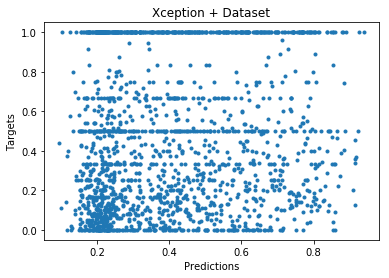

In [144]:
plt.plot(np.concatenate(preds, axis=0 ),np.concatenate(tars2, axis=0 ), '.')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.title('Xception + Dataset')
plt.savefig('xceptiontvsp.png', dpi=600)

In [127]:
mean_squared_error(np.concatenate(tars2, axis=0 ), np.concatenate( preds, axis=0 ))

0.15156503975320249

In [128]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(dset, tar)
pred_train = reg.predict(dset)
pred_test = reg.predict(dset_test)
mse_train = mean_squared_error(tar, pred_train)
mse_test = mean_squared_error(tar_test, pred_test)
print("Linear regression train mse: " + str(mse_train))
print("Linear regression test mse: " + str(mse_test))

Linear regression train mse: 0.11312879130139321
Linear regression test mse: 0.1559280318605168


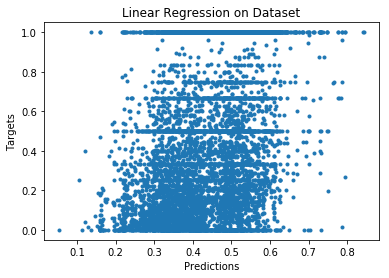

In [143]:
plt.plot(pred_train,tar, '.')
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.title('Linear Regression on Dataset')
plt.savefig('linregtvsp.png', dpi=600)

In [48]:
dset.to_csv("dset.csv")
tar.to_csv("tar.csv")
dset_test.to_csv("dset_test.csv")
tar_test.to_csv("tar_test.csv")

In [129]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5).fit(dset, tar)

pred_train = ridge.predict(dset)
pred_test = ridge.predict(dset_test)

mse_train = mean_squared_error(tar, pred_train)
mse_test = mean_squared_error(tar_test, pred_test)
print("Ridge train mse: " + str(mse_train))
print("Ridge test mse: " + str(mse_test))

Ridge train mse: 0.11315676959571686
Ridge test mse: 0.15570605666907814
